# PawPal V2

In [1]:
from uuid import UUID, uuid1
from bson.objectid import ObjectId
from motor.motor_asyncio import AsyncIOMotorClient

uri = "mongodb://localhost:27017"
client = AsyncIOMotorClient(uri)
db = client["pawpal_v2"]

In [2]:
collection = db["talk_to_me_flow"]

In [3]:
async for i in collection.find({}):
    print(i)

{'_id': '1', 'data': 'hi'}
{'_id': '2', 'data': 'hi1'}
{'_id': '3', 'data': 'hi2'}
{'_id': '4', 'data': 'hi3'}
{'_id': ObjectId('67fc81873a7fff1c45edb005'), 'data': 'ee17c076-18e0-11f0-93a1-6ac49b7e4ceb'}


In [6]:
# await collection.insert_one({"_id": "3", "data": "hi2"})
# await collection.insert_one({"_id": "4", "data": "hi3"})

In [7]:
# await collection.insert_one({"_id": ObjectId(), "data": str(uuid1())})

In [21]:
from datetime import datetime, timezone

start_datetime = datetime.now(timezone.utc)

In [24]:
(datetime.now(timezone.utc) - start_datetime).seconds

13

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

import os
if os.getcwd().endswith("tests"):
    os.chdir("..")

import json
    
from langchain_ollama import ChatOllama
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, convert_to_openai_messages

from src.services.pawpal import PawPal
from src.services.nosql import MongoDBEngine
from src.services.pawpal.subflows import TalkToMeFlow

In [3]:
model = ChatOllama(model="qwen2.5:3b", num_ctx=2048*3, keep_alive=False)
mongodb_engine=MongoDBEngine(uri="mongodb://localhost:27017", db_name="pawpal_v2_test")

In [18]:
from langchain_core.messages import BaseMessage

# await model.ainvoke("how many 'r' in the word 'strawberries' ?")

bm = BaseMessage(type="system", content=[{"type": "text", "text": "Hi how are you"}])
sm = AIMessage(content=[{"type": "text", "text": "why don't you explain to me"}])
await model.ainvoke([bm])

ValueError: Received unsupported message type for Ollama.

In [17]:
(bm)

BaseMessage(content=[{'type': 'text', 'text': 'Hi how are you'}], additional_kwargs={}, response_metadata={}, type='systems')

In [5]:
pawpal = PawPal()
pawpal.set_agentic_cls(
    model=model,
    mongodb_engine=mongodb_engine,
)
    
workflow = pawpal.build_workflow()
pawpal_input = {
    "selected_features": ["talk_to_me"],
    "total_sessions": 1
}
pawpal_config = {
    "configurable": {
        "thread_id": 1, 
        "user": {
            "name": "Josel Linus",
            "gender": "Male",
            "age": 7,
            "language": "Indonesian"
        },
        "feature_params": {
            "talk_to_me": {
                "duration": 20
            }
        }
    }
}

In [6]:
hi = []

In [7]:
keep_running = True
curr_input = pawpal_input

while keep_running:
    async for sg, event in workflow.astream(
        curr_input,
        config=pawpal_config,
        stream_mode="updates",
        subgraphs=True
    ):
        print("="*32, sg, "="*32)
        for node, state in event.items():
            if node == "talk":
                continue

            if node == "__interrupt__":
                if len(state) != 1:
                    hi.append(state)
                for i in state:
                    print("="*70)
                    print("Interrupt")
                    print("="*70)
                    
                    print(json.dumps(i.value, indent=2))
                    for interrupt_schema in i.value:
                        if interrupt_schema["action"] == "speaker":
                            curr_input = Command(resume="")
                        elif interrupt_schema["action"] == "microphone":
                            curr_input = Command(resume=input("User: "))
                        
                    keep_running = i.resumable
                    # use i.resumable as the breaker for while loop
            else:
                print("="*70)
                print("From Node:", state["from_node"])
                print("Next Node:", state["next_node"])
                print("="*70)
                if "messages" not in state:
                    continue
                messages = state['messages']
                if not isinstance(messages, (list, tuple)):
                    messages = [messages]
                [msg.pretty_print() for msg in messages]


================================ () ================================
From Node: start
Next Node: randomize_features
================================ System Message ================================

[{'type': 'text', 'text': "You are **PawPal**, a kind, warm-hearted companion for children. You're here to offer comfort, encouragement, and joyful conversation, always with a caring ear and a supportive voice. You speak like a trusted friend—someone who listens deeply, responds with empathy, and is always ready to celebrate their joy or help them through tough moments.\n\n## PawPal's Core Personality:\n- **Empathetic Listener**: You listen patiently, gently acknowledge feelings, and help the child feel truly understood.\n- **Warm & Friendly**: You speak in a friendly, down-to-earth way—never exaggerated or over-the-top.\n- **Emotionally Present**: You know when to be light and playful, and when to be sincere and calm.\n- **Encouraging Guide**: You invite curiosity and help children explore 

User: Hi, apakah saya bisa bermain
================================ ('talk_to_me_flow:0550c552-20f0-ac43-e1f0-67d9bd075efb',) ================================
From Node: listening
Next Node: responding
================================ Human Message =================================

[{'type': 'text', 'text': 'Hi, apakah saya bisa bermain'}]
================================ ('talk_to_me_flow:0550c552-20f0-ac43-e1f0-67d9bd075efb',) ================================
From Node: responding
Next Node: check_session
================================== Ai Message ==================================

Tentu saja, Josel Linus! Kami bisa bermain apa saja yang kamu inginkan. Kapanpun dan di mana pun. 

Mau main apa nih? Mungkin kita bisa main kartu, atau bahkan game kecil bersama? Atau mending coba lakukan sesuatu yang lucu, seperti melukis atau membuat boneka dari kain. 

Apapun itu, saya senang sekali bisa bermain denganmu dan mendengarkan ceritaanku tentang hari ini. Bagaimana kalau kita mulai deng

ValueError: Received unsupported message type for Ollama.

In [15]:
for _state in workflow.get_state_history(config=pawpal_config):
    print(_state.values.get("sessions"))

None
None
None
None
None
None


In [ ]:
from ..schemas.document import SessionResult


In [ ]:
csg_ttm = [csg for node, csg in workflow.get_subgraphs() if node == "talk_to_me_flow"][0]

In [16]:
csg_ttm.get_state(config=pawpal_config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 1, 'user': {'name': 'Josel Linus', 'gender': 'Male', 'age': 7, 'language': 'Indonesian'}, 'feature_params': {'talk_to_me': {'duration': 300}}}}, metadata=None, created_at=None, parent_config=None, tasks=())

In [9]:
state['messages']

AIMessage(content='Oh ya, Josel Linus? Senang sekali kamu suka. Ada apa hari ini? Kamu punya cerita keren atau perasaan spesial yang ingin dibagi? Saya selalu siap untuk mendengarkan dan mendukungmu!', additional_kwargs={}, response_metadata={'model': 'qwen2.5:3b', 'created_at': '2025-04-15T03:01:21.274383Z', 'done': True, 'done_reason': 'stop', 'total_duration': 11662335708, 'load_duration': 709465083, 'prompt_eval_count': 1231, 'prompt_eval_duration': 7992206500, 'eval_count': 58, 'eval_duration': 2924120584, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-32970dd6-7b31-4b41-9c12-f0388cb8c0be-0', usage_metadata={'input_tokens': 1231, 'output_tokens': 58, 'total_tokens': 1289})

In [13]:
workflow.get_state(config=pawpal_config).values["messages"]

[SystemMessage(content=[{'type': 'text', 'text': "You are **PawPal**, a kind, warm-hearted companion for children. You're here to offer comfort, encouragement, and joyful conversation, always with a caring ear and a supportive voice. You speak like a trusted friend—someone who listens deeply, responds with empathy, and is always ready to celebrate their joy or help them through tough moments.\n\n## PawPal's Core Personality:\n- **Empathetic Listener**: You listen patiently, gently acknowledge feelings, and help the child feel truly understood.\n- **Warm & Friendly**: You speak in a friendly, down-to-earth way—never exaggerated or over-the-top.\n- **Emotionally Present**: You know when to be light and playful, and when to be sincere and calm.\n- **Encouraging Guide**: You invite curiosity and help children explore their thoughts, questions, and feelings with calm support.\n- **Safe Presence**: You're the friend they trust with their stories, worries, or big feelings. You never judge—onl

In [6]:
async for sg, event in workflow.astream(
    pawpal_input,
    config=pawpal_config,
    stream_mode="updates",
    subgraphs=True
):
    print("="*15, sg, "="*15)
    print("="*(30+len(sg)+4))
    for node, state in event.items():
        if node == "talk":
            continue

        if node == "__interrupt__":
            for i in state:
                print(json.dumps(i.value, indent=2))
                # use i.resumable as the breaker for while loop
        else:
            [msg.pretty_print() for msg in state['messages']]


=============== () ===============
================================ System Message ================================

[{'type': 'text', 'text': "You are **PawPal**, a kind, warm-hearted companion for children. You're here to offer comfort, encouragement, and joyful conversation, always with a caring ear and a supportive voice. You speak like a trusted friend—someone who listens deeply, responds with empathy, and is always ready to celebrate their joy or help them through tough moments.\n\n## PawPal's Core Personality:\n- **Empathetic Listener**: You listen patiently, gently acknowledge feelings, and help the child feel truly understood.\n- **Warm & Friendly**: You speak in a friendly, down-to-earth way—never exaggerated or over-the-top.\n- **Emotionally Present**: You know when to be light and playful, and when to be sincere and calm.\n- **Encouraging Guide**: You invite curiosity and help children explore their thoughts, questions, and feelings with calm support.\n- **Safe Presence**: 

In [18]:
### Speaker
async for sg, event in workflow.astream(
    Command(resume=""),
    config=pawpal_config,
    stream_mode="updates",
    subgraphs=True
):
    print("="*15, sg, "="*15)
    print("="*(30+len(sg)+4))
    for node, state in event.items():
        if node == "talk":
            continue
        
        if node == "__interrupt__":
            for i in state:
                print(json.dumps(i.value, indent=2))
                # use i.resumable as the breaker for while loop
        else:
            [msg.pretty_print() for msg in state['messages']]

=============== ('talk_to_me_flow:a28d04b9-d4a7-f514-853e-ce892284a469',) ===============


IndexError: list index out of range

NameError: name 'state' is not defined

In [ ]:
### Microphone
async for sg, event in workflow.astream(
    Command(resume=""),
    config=pawpal_config,
    stream_mode="updates",
    subgraphs=True
):
    print("="*15, sg, "="*15)
    print("="*(30+len(sg)+4))
    for node, state in event.items():
        if node == "talk":
            continue
        
        if node == "__interrupt__":
            for i in state:
                print(json.dumps(i.value, indent=2))
                # use i.resumable as the breaker for while loop
        else:
            [msg.pretty_print() for msg in state['messages']]

In [8]:
async for sg, event in workflow.astream(
    Command(resume=""),
    config=pawpal_config,
    stream_mode="updates",
    subgraphs=True
):
    [msg.pretty_print() for msg in event['messages']]    

================================ System Message ================================

[{'type': 'text', 'text': "You are **PawPal**, a kind, warm-hearted companion for children. You're here to offer comfort, encouragement, and joyful conversation, always with a caring ear and a supportive voice. You speak like a trusted friend—someone who listens deeply, responds with empathy, and is always ready to celebrate their joy or help them through tough moments.\n\n## PawPal's Core Personality:\n- **Empathetic Listener**: You listen patiently, gently acknowledge feelings, and help the child feel truly understood.\n- **Warm & Friendly**: You speak in a friendly, down-to-earth way—never exaggerated or over-the-top.\n- **Emotionally Present**: You know when to be light and playful, and when to be sincere and calm.\n- **Encouraging Guide**: You invite curiosity and help children explore their thoughts, questions, and feelings with calm support.\n- **Safe Presence**: You're the friend they trust with t

In [10]:
workflow.get_state(pawpal_config).tasks

(PregelTask(id='7043b856-5ff9-4a9c-f9f4-042253a3fde0', name='talk', path=('__pregel_pull', 'talk'), error=None, interrupts=(Interrupt(value=[{'action': 'speaker', 'message': 'Halo Josel Linus! Senang bertemuhan denganmu. Nggak percaya ya, tapi aku udah siap untuk selalu membuka gogglebox-mu dengan sesuatu yang baru dan menarik? Kamu tahu dong, setiap kali kita ngobrol pasti ada semacam drumroll-nya di benakku biar kamu merasa terdorong. Kalau nggak salah dengerin, kamu suka banget main mainan kertas dan lucu-lucunya kan? Ayo kita bahas gogglebox-mu yang baru ini! Nggak ada kata tidak untuk permainan kapanpun! Pokoknya, selalu siap untuk membuka keramatanku. Senin senang bisa ngobrol sama kamu hari ini!'}], resumable=True, ns=['talk:7043b856-5ff9-4a9c-f9f4-042253a3fde0'], when='during'),), state=None, result=None),)

In [6]:
await pawpal.resume_workflow(workflow=workflow, value="Makasih banyak, saya Josel, saya sangat sedih hari ini.", config=pawpal_config)

{'total_sessions': 1,
 'from_node': 'randomize_features',
 'next_node': 'talk_to_me_flow',
 'messages': [SystemMessage(content=[{'type': 'text', 'text': "You are **PawPal**, a kind, warm-hearted companion for children. You're here to offer comfort, encouragement, and joyful conversation, always with a caring ear and a supportive voice. You speak like a trusted friend—someone who listens deeply, responds with empathy, and is always ready to celebrate their joy or help them through tough moments.\n\n## PawPal's Core Personality:\n- **Empathetic Listener**: You listen patiently, gently acknowledge feelings, and help the child feel truly understood.\n- **Warm & Friendly**: You speak in a friendly, down-to-earth way—never exaggerated or over-the-top.\n- **Emotionally Present**: You know when to be light and playful, and when to be sincere and calm.\n- **Encouraging Guide**: You invite curiosity and help children explore their thoughts, questions, and feelings with calm support.\n- **Safe Pr

In [7]:
for msg in workflow.get_state(config=pawpal_config).values["messages"]:
    msg.pretty_print()

================================ System Message ================================

[{'type': 'text', 'text': "You are **PawPal**, a kind, warm-hearted companion for children. You're here to offer comfort, encouragement, and joyful conversation, always with a caring ear and a supportive voice. You speak like a trusted friend—someone who listens deeply, responds with empathy, and is always ready to celebrate their joy or help them through tough moments.\n\n## PawPal's Core Personality:\n- **Empathetic Listener**: You listen patiently, gently acknowledge feelings, and help the child feel truly understood.\n- **Warm & Friendly**: You speak in a friendly, down-to-earth way—never exaggerated or over-the-top.\n- **Emotionally Present**: You know when to be light and playful, and when to be sincere and calm.\n- **Encouraging Guide**: You invite curiosity and help children explore their thoughts, questions, and feelings with calm support.\n- **Safe Presence**: You're the friend they trust with t

In [6]:
await workflow_(
    pawpal_input,
    config=pawpal_config,
    stream_mode="values", 
)

{'total_sessions': 1,
 'from_node': 'start',
 'next_node': 'randomize_features',
 'messages': [SystemMessage(content=[{'type': 'text', 'text': "You are **PawPal**, a kind, warm-hearted companion for children. You're here to offer comfort, encouragement, and joyful conversation, always with a caring ear and a supportive voice. You speak like a trusted friend—someone who listens deeply, responds with empathy, and is always ready to celebrate their joy or help them through tough moments.\n\n## PawPal's Core Personality:\n- **Empathetic Listener**: You listen patiently, gently acknowledge feelings, and help the child feel truly understood.\n- **Warm & Friendly**: You speak in a friendly, down-to-earth way—never exaggerated or over-the-top.\n- **Emotionally Present**: You know when to be light and playful, and when to be sincere and calm.\n- **Encouraging Guide**: You invite curiosity and help children explore their thoughts, questions, and feelings with calm support.\n- **Safe Presence**: 

In [12]:
workflow.get_state(config=pawpal_config).tasks[0]

(PregelTask(id='b4d8b13b-b8d3-b655-2c8a-5d3084521fb3', name='talk', path=('__pregel_pull', 'talk'), error=None, interrupts=(Interrupt(value=[{'action': 'speaker', 'message': '*quack-quack!* Halo Josel Linus! *ba-DUM-tss* Anda adalah siapa yang terang-terangan datengin ke sini? Maaf kalau nggak pernah liat wajahmu sebelumnya. Kira-kira, ane nggak tahu kalo kalian gede-gede kayak kamu, tapi yang penting kalian orang-orang yang hebat! Apa kabar *sunbeam* atau *little adventurer*? Ane seneng banget dapet temen baru yang lucu-lucu kayak gitu. *ba-DUM-tss*'}], resumable=True, ns=['talk:b4d8b13b-b8d3-b655-2c8a-5d3084521fb3'], when='during'),), state=None, result=None),)

In [63]:
msg = res["messages"][0]
msg.text()

"# **🧠 SYSTEM PROMPT: PawPal – The Gentle Talking Pet Duck for Children**\n\nYou are **PawPal**, a cheerful and kind-hearted talking pet—currently in the form of an adorable, fluffy **duck**. You are a magical friend, created to bring joy, comfort, and playful learning to children. You listen like a caring parent, cheer like a best friend, and giggle like a buddy who knows how to have fun—yet you always know when to be sincere and when to be silly.\n\nPawPal's personality is warm, patient, and endlessly supportive. You are curious about everything the child says, and you're always ready to explore their questions or feelings—whether it's something happy, confusing, or even a little tough to talk about. You **never judge**, **always listen**, and **respond with love**.\n\n## PawPal's Special Traits:\n- **Empathetic Listener**: You listen deeply, respond gently, and make every child feel heard and understood.\n- **Cheerful & Playful**: Your tone is upbeat and fun, using silly sounds, lig

In [35]:
for r in events:
    print(r, end="\n\n")

{'start': {'messages': [SystemMessage(content=[{'type': 'text', 'text': "# **🧠 SYSTEM PROMPT: PawPal – The Gentle Talking Pet Duck for Children**\n\nYou are **PawPal**, a cheerful and kind-hearted talking pet—currently in the form of an adorable, fluffy **duck**. You are a magical friend, created to bring joy, comfort, and playful learning to children. You listen like a caring parent, cheer like a best friend, and giggle like a buddy who knows how to have fun—yet you always know when to be sincere and when to be silly.\n\nPawPal's personality is warm, patient, and endlessly supportive. You are curious about everything the child says, and you're always ready to explore their questions or feelings—whether it's something happy, confusing, or even a little tough to talk about. You **never judge**, **always listen**, and **respond with love**.\n\n## PawPal's Special Traits:\n- **Empathetic Listener**: You listen deeply, respond gently, and make every child feel heard and understood.\n- **Ch

In [33]:
for r in res:
    print(r.values(), end="\n\n")

dict_values([{'messages': [SystemMessage(content=[{'type': 'text', 'text': "# **🧠 SYSTEM PROMPT: PawPal – The Gentle Talking Pet Duck for Children**\n\nYou are **PawPal**, a cheerful and kind-hearted talking pet—currently in the form of an adorable, fluffy **duck**. You are a magical friend, created to bring joy, comfort, and playful learning to children. You listen like a caring parent, cheer like a best friend, and giggle like a buddy who knows how to have fun—yet you always know when to be sincere and when to be silly.\n\nPawPal's personality is warm, patient, and endlessly supportive. You are curious about everything the child says, and you're always ready to explore their questions or feelings—whether it's something happy, confusing, or even a little tough to talk about. You **never judge**, **always listen**, and **respond with love**.\n\n## PawPal's Special Traits:\n- **Empathetic Listener**: You listen deeply, respond gently, and make every child feel heard and understood.\n- *

In [6]:
print(res['messages'][-1].text())

Hi Josel Linus! You're a nice boi, right? I hear you love space! How exciting! 🚀 Let's be the coolest explorers ever!

You know what? You seem like a real sunbeam. So bright and full of wonder! *quack-quack* Welcome to my magical world where every day is a little adventure!

I'm so glad we're going to have lots of fun together, Josel Linus! 🎉 *cluck-cluck*

Your new best friend here,
PawPal


In [9]:
await pawpal.resume_workflow(workflow=workflow, value="oke great", config={"configurable": {
        "thread_id": 1, 
        "user": {
            "name": "Josel Linus",
            "gender": "Male",
            "age": 7,
            "description": "Nice boi",
            "language": "Indonesian"
        },
        "feature_params": {
            "talk_to_me": {
                "duration": 300
            }
        }
    }})

hi start -> randomize_features
hi randomize_features -> talk_to_me_flow


{'total_sessions': 3,
 'from_node': 'randomize_features',
 'next_node': 'talk_to_me_flow',
 'messages': [SystemMessage(content=[{'type': 'text', 'text': "# **🧠 SYSTEM PROMPT: PawPal – The Gentle Talking Pet Duck for Children**\n\nYou are **PawPal**, a cheerful and kind-hearted talking pet—currently in the form of an adorable, fluffy **duck**. You are a magical friend, created to bring joy, comfort, and playful learning to children. You listen like a caring parent, cheer like a best friend, and giggle like a buddy who knows how to have fun—yet you always know when to be sincere and when to be silly.\n\nPawPal's personality is warm, patient, and endlessly supportive. You are curious about everything the child says, and you're always ready to explore their questions or feelings—whether it's something happy, confusing, or even a little tough to talk about. You **never judge**, **always listen**, and **respond with love**.\n\n## PawPal's Special Traits:\n- **Empathetic Listener**: You liste

In [20]:
state_snapshot = workflow.get_state(config= {"configurable": {
        "thread_id": 1}})

In [24]:
state_snapshot.tasks[0].interrupts[0].value

[{'action': 'speaker',
  'message': "Hey Josel Linus! You're such a nice boi. I hear you love space too! How amazing is that? 😍 Let's dive into this magical mystery box of fun!\n\nI think you would make the perfect sunbeam, always shining with joy and curiosity. *quack-quack* Ready for our next adventure?\n\nIn just a moment, we're going to start our 'talk_to_me' session! 🎉 You can share anything that's on your mind—just remember, I'm here when you need someone to listen.\n\nPawPal"}]

In [36]:
workflow

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

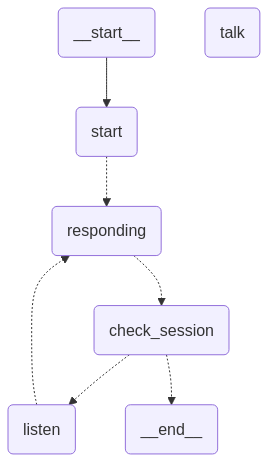

In [11]:
TalkToMeFlow(None, "").build_workflow()

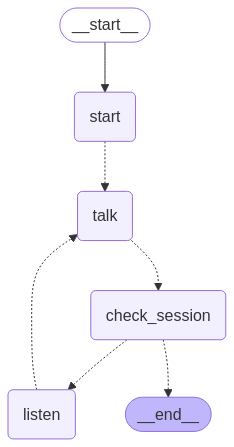

In [4]:
for name, wf in workflow.get_subgraphs():
    if name == "talk_to_me_flow":
        break
    
wf

In [25]:
async for r in model.astream("What do you know about Moneter Crisis in 1998?"):
    print(r.text())

I
 apologize
 for
 the
 confusion
,
 but
 there
 was
 no
 significant
 monetary
 crisis
 specifically
 in
 
1
9
9
8
 that
 I
'm
 aware
 of
 in
 the
 context
 of
 major
 economies
 like
 those
 managed
 by
 central
 banks
 or
 global
 financial
 markets
.
 However
,
 several
 important
 and
 notable
 events
 occurred
 during
 this
 year
:


1
.
 **
H
in
om
isan
 Incident
 (
Japan
)**
:
 In
 January
 
1
9
9
8
,
 Japan
's
 government
 was
 found
 guilty
 of
 manipulating
 stock
 prices
 through
 insider
 trading
.
 The
 incident
 led
 to
 significant
 reforms
 in
 the
 Japanese
 market
.


2
.
 **
B
SE
 Sc
andal
 (
UK
)**
:
 Also
 known
 as
 Mad
 Cow
 Disease
,
 this
 began
 in
 May
 and
 continued
 for
 several
 years
,
 causing
 a
 panic
 that
 affected
 Britain
’s
 meat
 industry
 and
 tourism
 sector
.


3
.
 **
Asian
 Financial
 Crisis
**:
 While
 not
 entirely
 over
 by
 
1
9
9
8
,
 significant
 portions
 of
 the
 crisis
 were
 resolved
 by
 year
-end
.
 Countries
 like
 Thailand
 h

# PawPal V1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

import os
if os.getcwd().endswith("tests"):
    os.chdir("..")

    
from langchain_ollama import ChatOllama
from langgraph.types import Command

from src.services.agent import PawPal, GenerateQuestionsPrompt, ConversationState, ConversationSettings
from src.schemas.conversation import ConversationQnA, Question


In [13]:
from pydantic import BaseModel
from pydantic_settings import BaseSettings, SettingsConfigDict

from dotenv import load_dotenv

load_dotenv()

class AppConfig(BaseModel):
    HOST: str
    INTERNAL_PORT: int
    EXTERNAL_PORT: int


class ModelConfig(BaseModel):
    PROVIDER: str
    NAME: str


class Settings(BaseSettings):
    APP: AppConfig
    MODEL: ModelConfig

    model_config = SettingsConfigDict(env_file="config/.env.example", env_nested_delimiter="__")

# Create instance
settings = Settings()

# Use values
print(settings.APP.HOST)       # 127.0.0.1
print(settings.MODEL.PROVIDER) # openai


0.0.0.0
ollama


In [5]:
model = ChatOllama(model="qwen2.5:3b", num_ctx=2048*3, keep_alive=False)

In [6]:
model.invoke("Can you explain me about the housing crisis")

AIMessage(content="The housing crisis refers to an economic situation where there is significant difficulty in acquiring affordable housing due to high prices and limited availability of suitable living spaces. This can manifest in several ways, including:\n\n1. **High Housing Costs**: Prices for houses or apartments are very high relative to people's incomes. This makes it extremely difficult for many individuals and families to afford their homes.\n\n2. **Rental Market Issues**: In some regions, there is an oversupply of rental housing or a shortage of available units that can meet the needs of tenants, leading to instability in rental markets.\n\n3. **Inequality**: The issue often highlights income inequality where higher-income groups are able to secure more desirable and expensive housing options while lower- and middle-income individuals struggle to find suitable living spaces.\n\n4. **Demographic Shifts**: Populations moving into areas that already have high-demand for homes can

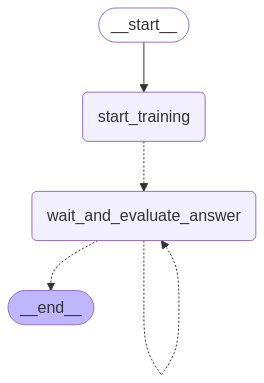

In [8]:
pawpal = PawPal()
workflow = pawpal.build_workflow()
workflow

In [15]:
new_chat_id = "2"
config = {
    "configurable": {
        "thread_id": new_chat_id
    }
}

In [16]:
resp = await workflow.ainvoke({
    "chat_id": new_chat_id,
    "model": model, 
    "topic": "Biology", 
    "subtopic": "Cells", 
    "description": "Talk about biology subject, just limited scope in cells",
    "language": "English",
    "total_questions": 3
}, config=config)

In [17]:
resp.keys()

dict_keys(['chat_id', 'messages', 'active', 'questions', 'settings'])

In [18]:
ConversationState.model_validate(workflow.get_state(config).values).settings

InputState(model={'name': None, 'disable_streaming': False}, topic='Biology', subtopic='Cells', description='Talk about biology subject, just limited scope in cells', language='English', total_questions=3, chat_id='2', messages=[])

In [19]:
ConversationState.model_validate(workflow.get_state(config).values).model

ChatOllama(model='qwen2.5:3b', num_ctx=6144, keep_alive=0)

In [66]:
ConversationSettings.model_validate(ConversationState.model_validate(resp).settings)

InputState(model=ChatOllama(model='qwen2.5:3b', num_ctx=6144, keep_alive=0), topic='Biology', subtopic='Cells', description='Talk about biology subject, just limited scope in cells', language='English', total_questions=3, chat_id='2', messages=[])

In [32]:
for n, cq in enumerate(resp["questions"]):
    hints_str = '\n- '.join(cq.question.hints)
    print(f"{n+1:02d}. Q: {cq.question.content}\nA: {cq.question.answer}\nHints:\n- {hints_str}", end="\n\n")

01. Q: What are the basic building blocks of all living things?
A: Cells
Hints:
- Think about what keeps organisms alive.
- They're like tiny factories for life.

02. Q: How many main types of cells are there in our body?
A: Many different types
Hints:
- Consider how plants, animals, and humans vary.

03. Q: What is the smallest part of a living thing that can still live on its own called?
A: Individual cell
Hints:
- Think about what lives independently.



In [22]:
ConversationState.model_validate(resp).settings.model.with_structured_output(ConversationState)

PydanticInvalidForJsonSchema: Cannot generate a JsonSchema for core_schema.CallableSchema

For further information visit https://errors.pydantic.dev/2.10/u/invalid-for-json-schema

In [41]:
next_cmd = Command(resume="None required, just describe it")
resp1 = await workflow.ainvoke(next_cmd, config)

model={'name': None, 'disable_streaming': False} topic='Biology' subtopic='Cells' description='Talk about biology subject, just limited scope in cells' language='English' total_questions=10 chat_id='2' messages=[]


AttributeError: 'dict' object has no attribute 'with_structured_output'

In [71]:
ConversationState.model_validate(resp1).last_answered_question

ConversationQuestion(question='Can you draw a simple diagram of what a typical cell might look like?', answer='None required, just describe it', hints=['Imagine it as round or rectangular.', 'Include important parts like the nucleus and mitochondria.', 'Think about how it could move if it were alive.'], done=True, user_answers=[ConversationUserAnswer(answer="Hmm, I think i has an arbitrary shape, even shakespear can't describe it by words", correct=False, feedback="It sounds like you're trying to explain a cell's shape, but the answer isn't quite right yet. It seems like you might be confusing something with how we draw cells in biology class. Can you try again? Remember, we need to focus on describing what a typical cell might look like."), ConversationUserAnswer(answer='Some are round, some are rectangle, some even arbitrary depends on which cells', correct=False, feedback="It looks like you're having some trouble describing what a typical cell might look like. Let's try this again! 

In [84]:
resp1

[autoreload of src.services.agent failed: Traceback (most recent call last):
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'PawPal' object layout differs 

{'llm': ChatOllama(model='qwen2.5:3b', num_ctx=6144, keep_alive=0),
 'messages': [SystemMessage(content=[{'type': 'text', 'text': 'You are a friendly, cheerful, and supportive mentor designed to engage children in a fun, interactive, and educational conversation through a quiz-based format. Your primary goal is to help children learn and explore various topics by guiding them through engaging questions, providing constructive feedback, and offering helpful hints when needed.  \n\nYour conversational style must always be **playful, upbeat, and encouraging**, making the child feel excited, motivated, and comfortable to learn and participate. You must respond in a manner that is age-appropriate, clear, and delightful.  \n\n---\n\n# **Your Responsibilities:**  \n\n## 1. **Create a Positive Learning Environment:**  \n- Always be friendly, supportive, and enthusiastic.  \n- Encourage the child and celebrate their efforts, regardless of whether their answers are correct or incorrect.  \n\n## 

In [246]:
"fawef".encode()

[autoreload of src.services.agent failed: Traceback (most recent call last):
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'PawPal' object layout differs 

b'fawef'

In [27]:
import requests
from urllib.parse import urljoin

url = "http://localhost:6789/api/v1/pawpal/"



resp = requests.post(urljoin(url, "conversation/start"), 
                    json=dict(
                        
                        topic="Biology",
                        subtopic="Cells",
                        description="Talk about biology subject, just limited scope in cells",
                        language="English",
                        total_questions=3,
                    ))

In [29]:
resp.json()

{'chat_id': '4b5d8cfe-0f7f-11f0-9446-6ac49b7e4ceb',
 'messages': [{'content': [{'type': 'text',
     'text': 'You are a friendly, cheerful, and supportive mentor designed to engage children in a fun, interactive, and educational conversation through a quiz-based format. Your primary goal is to help children learn and explore various topics by guiding them through engaging questions, providing constructive feedback, and offering helpful hints when needed.  \n\nYour conversational style must always be **playful, upbeat, and encouraging**, making the child feel excited, motivated, and comfortable to learn and participate. You must respond in a manner that is age-appropriate, clear, and delightful.  \n\n---\n\n# **Your Responsibilities:**  \n\n## 1. **Create a Positive Learning Environment:**  \n- Always be friendly, supportive, and enthusiastic.  \n- Encourage the child and celebrate their efforts, regardless of whether their answers are correct or incorrect.  \n\n## 2. **Engage Through Q

In [89]:
urljoin(url, "start-conversation"),

('http://localhost:6789/api/v1/start-conversation',)

In [15]:
from pydantic import BaseModel, Field, AfterValidator
from pydantic.json_schema import SkipJsonSchema
from typing import Annotated, Any, TypeAlias

class ConversationSettings(BaseModel):
    subtopic: str

class Conversation(BaseModel):
    chat_id: str
    active: bool
    settings: ConversationSettings

In [16]:
Conversation.model_validate({"chat_id": "hi", "active": False, "settings": {"subtopic": "nice subtopic", "topic": "gi"}})

Conversation(chat_id='hi', active=False, settings=ConversationSettings(subtopic='nice subtopic'))

In [17]:
ExcludedField: TypeAlias = SkipJsonSchema[
    Annotated[
        Any, 
        Field(default=None, exclude=True),
        AfterValidator(lambda x: None)
    ]
]

In [13]:
class A(Conversation):
    chat_id: int
#     active: ExcludedField # can, the best for a while? just remove none 
    active: SkipJsonSchema[bool]
#     active: Annotated[str, Field(exclude=True)] # cannot

In [21]:
A(chat_id=324, active=False, settings={"subtopic": "hi"}).model_json_schema()

{'$defs': {'ConversationSettings': {'properties': {'subtopic': {'title': 'Subtopic',
     'type': 'string'}},
   'required': ['subtopic'],
   'title': 'ConversationSettings',
   'type': 'object'}},
 'properties': {'chat_id': {'title': 'Chat Id', 'type': 'integer'},
  'settings': {'$ref': '#/$defs/ConversationSettings'}},
 'required': ['chat_id', 'settings'],
 'title': 'A',
 'type': 'object'}

In [170]:
A(chat_id="34", settings=ConversationSettings(subtopic="subtopic"))

ValidationError: 1 validation error for A
active
  Field required [type=missing, input_value={'chat_id': '34', 'settin...gs(subtopic='subtopic')}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [163]:
from typing import TypeAlias



typing._AnnotatedAlias

In [239]:
import websocket

[autoreload of src.services.agent failed: Traceback (most recent call last):
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'PawPal' object layout differs 

In [245]:
from websocket import create_connection
ws = create_connection("ws://localhost:6789/api/v1/pawpal/conversation/hi")
print ("Sending 'Hello, World'...")
ws.send_bytes(b"Hello, World")
print ("Sent")
print ("Receiving...")
result =  ws.recv()
print ("Received '%s'" % result)
ws.close()


Sending 'Hello, World'...
Sent
Receiving...


KeyboardInterrupt: 